## This file is used to get forecasting data and error

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import math
from math import sqrt
import re
from datetime import datetime
import datetime
from sklearn import preprocessing
import sys

In [40]:
hist_data = pd.read_csv("data/base_data.csv")

In [41]:
hist_data.Day = pd.to_datetime(hist_data.Day)

In [42]:
season = {1:'Winter', 2:'Spring', 3:'Spring', 4:'Spring', 5:'Summer', 6:'Summer', 7:'Summer',\
         8:'Fall', 9:'Fall', 10:'Fall', 11:'Winter', 12:'Winter'}

#normalization
Cha = ['TMP','WNDCHILL','WNDSPD','Humidity','PRMSL','RAIN']
min_max_scaler = preprocessing.MinMaxScaler()
hist_data[Cha] = min_max_scaler.fit_transform(hist_data[Cha]) 

In [219]:
#target_date info.
target_year = 2020  
target_month = 5
target_day = 7

In [220]:
target_season = season[target_month]

target_date = datetime.date(target_year, target_month, target_day)
target_weekday = target_date.weekday() + 1

In [221]:
tar_weather = pd.read_csv("data/target_day_weather.csv", sep=',')

In [222]:
# get omega_A
omega_A = hist_data[(hist_data.Season == target_season) & (hist_data.weekday == target_weekday)]

In [223]:
def get_omega_B(omega_A):
    time_lst = list(omega_A.Day.unique())
    selected = list(time_lst)[-10:]
    return selected

In [224]:
omega_B = get_omega_B(omega_A)

In [225]:
def weather_distance(X, target):
    time_series = pd.Series([0,2,4,6,8,10,12,14,16,18,20,22])
    
    del_T = time_series.apply(lambda x: abs(target[target.Hour == x].Temperature.values \
                              - X[(X.Hour == x)].TMP.values)[0])
    
    del_W = time_series.apply(lambda x: abs(target[target.Hour == x].Wind.values \
                              - X[(X.Hour == x)].WNDSPD.values)[0])
    
    del_H = time_series.apply(lambda x: abs(target[target.Hour == x].Humidity.values \
                              -  X[(X.Hour == x)].Humidity.values)[0])
    
    del_P = time_series.apply(lambda x: abs(target[target.Hour == x].Pressure.values \
                              - X[(X.Hour == x)].PRMSL.values)[0])
    
    del_R = time_series.apply(lambda x: abs(target[target.Hour == x].Rain.values \
                              - X[(X.Hour == x)].RAIN.values)[0])
    
    return [del_T[del_T.notnull()].mean(), del_W[del_W.notnull()].mean(), del_H[del_H.notnull()].mean(), \
           del_P[del_P.notnull()].mean(), del_R[del_R.notnull()].mean()]

In [226]:
del_matrix = list()
for i in omega_B:  
    del_matrix.append(weather_distance(omega_A[omega_A.Day == i], tar_weather)) #got weather distance of Omega_B's data

In [227]:
min_max_scaler = preprocessing.MinMaxScaler()
nor_mat = min_max_scaler.fit_transform(pd.DataFrame(del_matrix)).sum(axis = 1) #normalize the distance

In [228]:
weather_dic = dict(zip(omega_B, nor_mat))
sorted_wea_dis = sorted(weather_dic.items(), key=lambda d: d[1])

In [229]:
omega_C = [x[0] for x in sorted_wea_dis[:5]]

#### average sampled data to get demand file   and get error matrix

In [230]:
sampled_data = hist_data[hist_data.Day.isin(omega_C)]

In [231]:
len(sampled_data) #120[hours] = 5[days] * 24[hours/day]

120

In [232]:
hour_lst = pd.Series(range(24))
Demand_pred = hour_lst.apply(lambda x: sampled_data[sampled_data.Hour == x].Power.mean())

Text(0.5, 0, 'Time [h]')

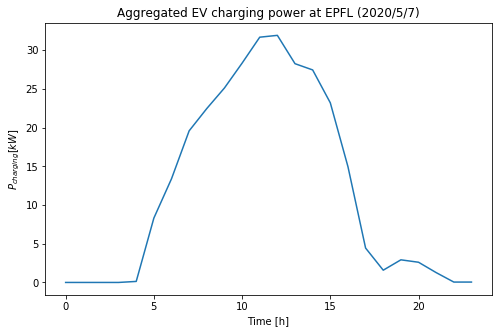

In [233]:
plt.figure(figsize=(8,5))
plt.plot(Demand_pred/1000)
plt.title('Aggregated EV charging power at EPFL (%d/%d/%d)'%(target_year,target_month,target_day))
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')

In [234]:
Err = list()
for i in omega_C:
    Err.append(sampled_data[sampled_data.Day == i]\
                    .Power.reset_index(drop = True) - Demand_pred)
    

In [235]:
Demand_pred

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4       131.650685
5      8314.660762
6     13395.427563
7     19589.938433
8     22470.419947
9     25125.405031
10    28334.640632
11    31689.178797
12    31926.244039
13    28264.686487
14    27459.016498
15    23209.130032
16    14962.607133
17     4442.265097
18     1583.807116
19     2922.381029
20     2609.813462
21     1271.239549
22       48.875912
23       48.875912
dtype: float64